# マルチエージェントシミュレーション

## Agents.jl

- [Agents.jl](https://juliadynamics.github.io/Agents.jl/stable/)
    - Julia でエージェントベースモデル (ABM) の構築を行うパッケージ
    - ABM パッケージの中でも高速
        - [Comparison of ABM Framwarks](https://juliadynamics.github.io/Agents.jl/stable/comparison/)

### マルチエージェントシミュレーション (MAS)
- 多数のエージェントを用いて仮想的な社会を作り、それらを用いて現実の様々な事象をモデル化するシミュレーション
    - **エージェント**:
        - 人間のように内部状態や行動ルールを持ち、自律的に意思決定を行うオブジェクト
- エージェントをベースとしてモデル化するため、エージェントベースモデル (ABM) とも呼ばれる


## シェリングの分居モデル

https://qiita.com/MandoNarin/items/cf7c0fb11e05e3a7094d

隣人の選り好みして満足いくまで引っ越すのを繰り返すというもので、満足度の基準が緩い場合であっても分居されてしまうという洞察が、コンピュータシミュレーションで明かされている

元ネタを辿るとアメリカにて黒人、白人の分居が起こる様子をコンピュータ上で再現しようとしたものがきっかけとなっている

In [1]:
using Agents

# 空間の定義: 10x10 のグリッドスペース
space = GridSpace((10, 10); periodic = false)

"""
    mutable struct SchellingAgent <: AbstractAgent

シェリングエージェントの定義

- `id::Int`: エージェントID
- `pos::NTuple{2, Int}`: 2Dグリッド上でのエージェント位置 `(x, y)`
- `mood::Bool`: エージェントが満足しているかを判定するフラグ (true: 満足, false: 不満)
- `group::Int`: エージェントグループ; エージェントは隣人との対話で満足度を変化させる
"""
mutable struct SchellingAgent <: AbstractAgent
    id::Int             # The identifier number of the agent
    pos::NTuple{2, Int} # The x, y location of the agent on a 2D grid
    mood::Bool          # whether the agent is happy in its position. (true = happy)
    group::Int          # The group of the agent, determines mood as it interacts with neighbors
end


Update message: Agents v5
Welcome to this new major version of Agents.jl!
Noteworthy changes:

* Schedulers have been reworked to be more performant and allocate
  less. This means that most scheduler names have been deprecated from
  functions to types, such as `by_type` -> `ByType`. See changelog for
  full list!
* See the CHANGELOG.md or online docs for more!


In [4]:
using Random

"""
    initialize(; n_agents = 320, griddims = (20, 20), min_to_be_happy = 3, seed = 125) = model::ABM{SchellingAgent}

エージェントモデルの初期化関数
"""
function initialize(; n_agents = 320, griddims = (20, 20), min_to_be_happy = 3, seed = 125)
    space = GridSpace(griddims, periodic = false)
    properties = Dict(:min_to_be_happy => min_to_be_happy)
    rng = Random.MersenneTwister(seed)
    model = ABM(
        SchellingAgent, space;
        properties, rng, scheduler = Schedulers.randomly
    )

    # populate the model with agents, adding equal amount of the two types of agents
    # at random positions in the model
    for n in 1:n_agents
        agent = SchellingAgent(n, (1, 1), false, n < n_agents / 2 ? 1 : 2)
        add_agent_single!(agent, model)
    end
    return model
end

"""
    agent_step!(agent, model)

エージェントの内部状態を更新するステップ関数
"""
function agent_step!(agent, model)
    minhappy = model.min_to_be_happy
    count_neighbors_same_group = 0
    # For each neighbor, get group and compare to current agent's group
    # and increment count_neighbors_same_group as appropriately.
    # Here `nearby_agents` (with default arguments) will provide an iterator
    # over the nearby agents one grid point away, which are at most 8.
    for neighbor in nearby_agents(agent, model)
        if agent.group == neighbor.group
            count_neighbors_same_group += 1
        end
    end
    # After counting the neighbors, decide whether or not to move the agent.
    # If count_neighbors_same_group is at least the min_to_be_happy, set the
    # mood to true. Otherwise, move the agent to a random position.
    if count_neighbors_same_group ≥ minhappy
        agent.mood = true
    else
        move_agent_single!(agent, model)
    end
    return
end

# SchellingAgent Base Model 生成
model = initialize()

AgentBasedModel with 320 agents of type SchellingAgent
 space: GridSpace with size (20, 20), metric=chebyshev, periodic=false
 scheduler: randomly
 properties: min_to_be_happy

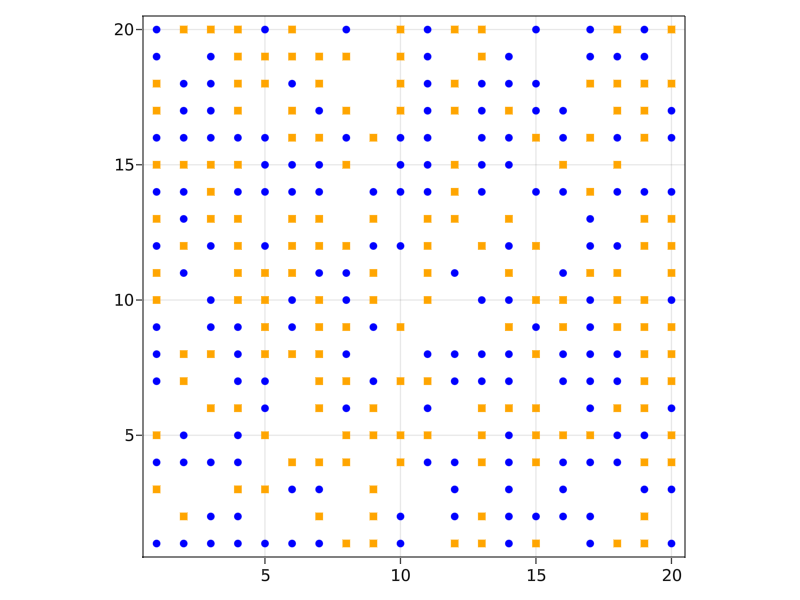

┌ Info: Makie is caching fonts, this may take a while. Needed only on first run!
└ @ Makie C:\Users\user\.julia\packages\Makie\lgPZh\src\utilities\texture_atlas.jl:118


In [6]:
"""
シミュレーションの可視化

https://gist.github.com/Datseris/e7e15d3559f8dc69d07bba051d904ebf#file-schelling-jl
"""

using InteractiveDynamics, GLMakie

groupcolor(a) = a.group == 1 ? :blue : :orange
groupmarker(a) = a.group == 1 ? :circle : :rect
figure, _ = abmplot(model; ac = groupcolor, am = groupmarker, as = 10)
figure # returning the figure displays it

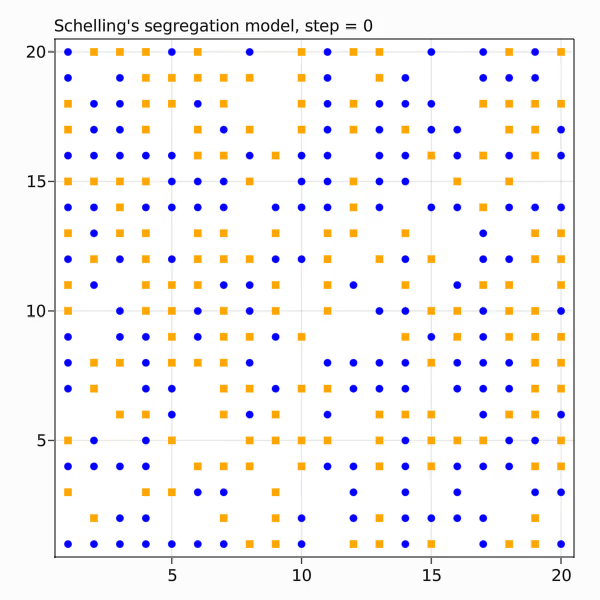

In [7]:
"""
シミュレーションの実行とアニメーション生成
"""

model = initialize()

abmvideo(
    "01-schelling.gif", model, agent_step!;
    ac = groupcolor, am = groupmarker, as = 10,
    framerate = 4, frames = 20,
    title = "Schelling's segregation model"
)

display("image/gif", read("01-schelling.gif"))